<a href="https://colab.research.google.com/github/idan424/AccuLine-noisy-ECG-classification-assignment/blob/main/Data_analysis_and_modeling_acculine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Change to our data directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AccuLine Assignment/DATA')

In [53]:
#@title Imports
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



In [ ]:
#@title Load data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Switch labels so that noisy == 1
y_train = (y_train == 0).astype(int)
y_test = (y_test == 0).astype(int)

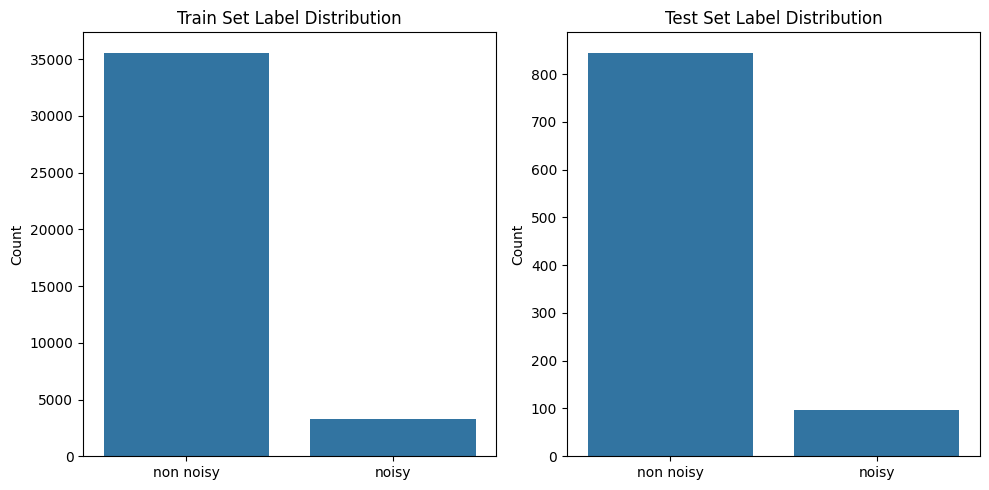

In [69]:
#@title label distribution

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot train set label distribution
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Train Set Label Distribution')
axes[0].set_xticks([0, 1], ['non noisy', 'noisy'])
axes[0].set_ylabel('Count')

# Plot test set label distribution
sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title('Test Set Label Distribution')
axes[1].set_xticks([0, 1], ['non noisy', 'noisy'])
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [54]:
# Here we use a manual min-max scaler to normalize every sample with respect to itself
# I added an epsilon to avoid division by 0 in constant signals
eps = 1e-9
min_max_normalize = lambda X: (X - X.min(axis=1)[:,None]) / ((X.max(axis=1) - X.min(axis=1)) + eps)[:, None]

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

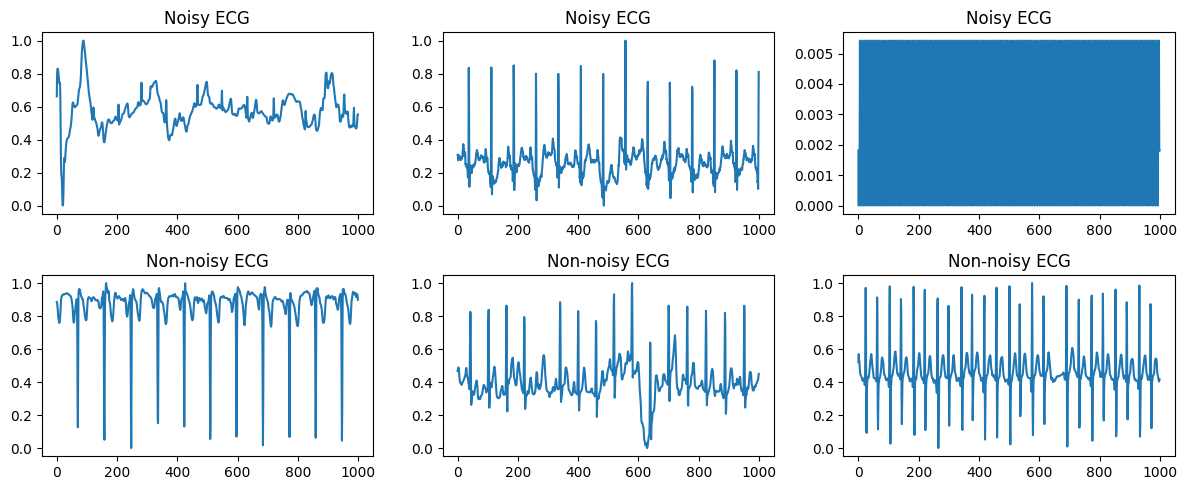

In [52]:
#@title Here's an example of some noisy and non noisy samples {run:'auto'}

# Find indices of noisy and non-noisy samples
noisy_indices = np.where(y_train == 1)[0]
non_noisy_indices = np.where(y_train == 0)[0]

n_signals = 3 # @param {type:"slider", min:1, max:5, step:1}

# Select 3 random indices for each label
noisy_samples = np.random.choice(noisy_indices, n_signals)
non_noisy_samples = np.random.choice(non_noisy_indices, n_signals)

# Plot the samples
fig, axs = plt.subplots(2, n_signals, figsize=(12, 5))
for i, sample_idx in enumerate(noisy_samples):
    axs[0, i].plot(X_train[sample_idx])
    axs[0, i].set_title('Noisy ECG')
for i, sample_idx in enumerate(non_noisy_samples):
    axs[1, i].plot(X_train[sample_idx])
    axs[1, i].set_title('Non-noisy ECG')

plt.tight_layout()
plt.show()


## Modeling

In [96]:
#@title util funcs:
def plot_cm(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def eval_model(y_pred, y_train):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    plot_cm(conf_matrix)



---

### <font color='red'> Logistic regression
> basic model, we dont expect this to be too good

<font color='cyan'> We'll start with the imbalanced data as it is


In [119]:
#@title train model - imbalanced
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)
_ = ''

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Eval Training set:
Accuracy: 0.9156131154281015
Precision: 0.9743589743589743
Recall: 0.011442336645588679
F1 Score: 0.022619047619047622


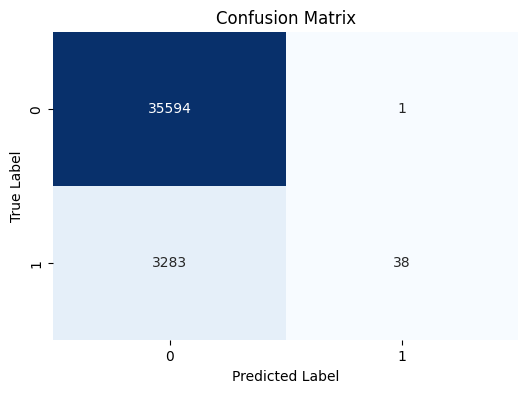

Eval Test set:
Accuracy: 0.89798087141339
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


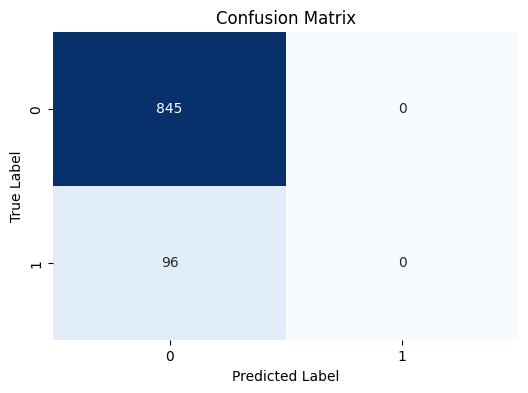

In [120]:
#@title eval model - imbalanced
print("Eval Training set:")
y_pred_train = model.predict(X_train)
eval_model(y_pred_train, y_train)

print("Eval Test set:")
y_pred_test = model.predict(X_test)
eval_model(y_pred_test, y_test)

<font color='red'> We can see that this model has a percision and recall of 0, meaning it doesn't think any signal is noisy

That's not helpfull at all</font>

<font color='cyan'> We should use the label ratio for class based penalazing

In [121]:
#@title train model
from sklearn.linear_model import LogisticRegression

# use label ratio for class weights - due to label imbalance
ratio_zeros_to_ones = (y_train == 0).sum() / (y_train == 1).sum()

class_weights = {0: 1, 1: ratio_zeros_to_ones}  # Larger penalty on label 1

# Initialize Logistic Regression model
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train, y_train)
_ = ''

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 10.718157181571815})

Eval Training set:
Accuracy: 0.6247301880974406
Precision: 0.14242251378589085
Recall: 0.6766034327009937
F1 Score: 0.23531259817781966


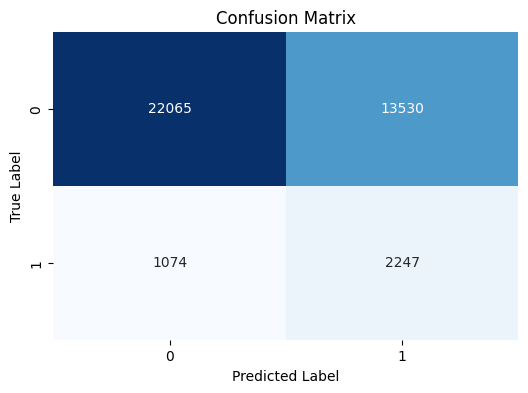

Eval Test set:
Accuracy: 0.5961742826780021
Precision: 0.11621621621621622
Recall: 0.4479166666666667
F1 Score: 0.18454935622317598


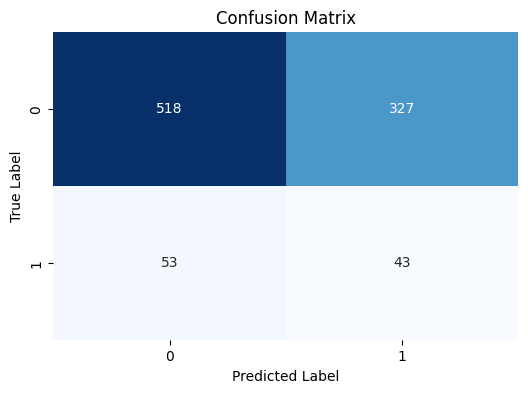

In [122]:
#@title eval model - balanced
print("Eval Training set:")
y_pred_train = model.predict(X_train)
eval_model(y_pred_train, y_train)

print("Eval Test set:")
y_pred_test = model.predict(X_test)
eval_model(y_pred_test, y_test)

<font color='red'>These results are better than what we had with no label balanced penalty

But for real-life applications this is far from acceptable</font>

<font color='orange'>Let's try a different model

---

### <font color='orange'> XGBoost </font>
> we expect better results from this model
>
> it's a lot better at dealing with non linear data, as well a s imbalanced data

<font color='cyan'> We'll use the label ratio for class based penalazing here

In [123]:
#@title train model
import xgboost as xgb

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(scale_pos_weight=ratio_zeros_to_ones)

# Train the model on the entire training data
xgb_model = xgb_model.fit(X_train, y_train, verbose=True)


Eval Training set:
Accuracy: 0.9914688046047898
Precision: 0.9122758620689655
Recall: 0.9957844022884673
F1 Score: 0.9522027065937231


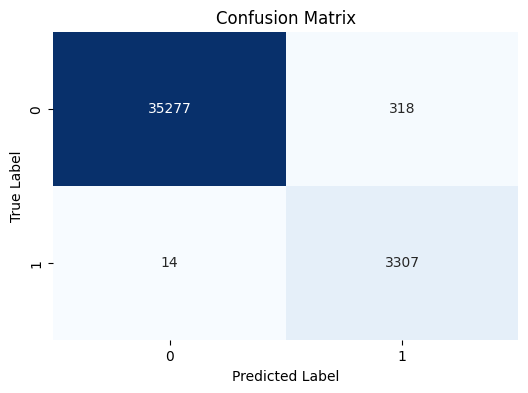

Eval Test set:
Accuracy: 0.9893730074388948
Precision: 0.93
Recall: 0.96875
F1 Score: 0.9489795918367346


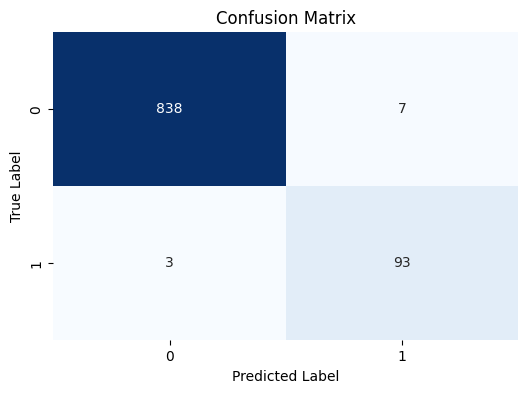

In [124]:
#@title eval model
print("Eval Training set:")
y_pred_train = xgb_model.predict(X_train)
eval_model(y_pred_train, y_train)

print("Eval Test set:")
y_pred_test = xgb_model.predict(X_test)
eval_model(y_pred_test, y_test)

<font color='orange'> This  model provides us with very good percision and recall results </font>

<font color='lime'> We'll save it for now </font>


In [126]:
#@title Save model

xgb_model.save_model('../XGBclassifier.json')


I chose this approach instead of a signal processing based type models (CNN/RNN) for 2 reasons:
1. XGBoost is a simple to use non-linear model, that clearly achieved very good results on this test set
2. I don't have a lot of data, XGBoost can perform well even with limited amounts of training data, whereas CNNs and RNNs typically require large amounts of data to learn complex patterns effectively.